# Imports

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

## Functions

In [131]:
def fill_missing(series: pd.Series) -> pd.Series:
    # 1. interpolation for internal gaps
    # 2. backward fill for leading NaNs
    # 3. forward fill for trailing NaNs
    return series.interpolate().bfill().ffill()

## D1 - general recylcing rates

In [132]:
d1 = pd.read_csv("raw_data/d1.csv")

In [133]:
res_d1 = d1.copy()
res_d1 = res_d1[['geo', 'TIME_PERIOD', "OBS_VALUE", "OBS_FLAG"]]
res_d1 = res_d1.rename(columns={"geo": "country_name",
                                "TIME_PERIOD": "year",
                                "OBS_VALUE": "recycling_rate",
                                "OBS_FLAG": "flag"})
res_d1['country_name'] = res_d1['country_name'].astype("string")
res_d1['year'] = res_d1['year'].astype(int)
res_d1['recycling_rate'] = res_d1['recycling_rate'].astype(float)
res_d1['flag'] = res_d1['flag'].astype("string")

missing_rates_d1 = pd.DataFrame(res_d1.groupby("country_name")["recycling_rate"].apply(lambda x: x.isna().mean())).reset_index()
missing_rates_d1.to_csv("processed_data/missing_value_rates_d1.csv", index=False)

values_to_drop_d1 = []
for index, row in missing_rates_d1.iterrows():
    if row['recycling_rate'] > 0.9:
        values_to_drop_d1.append(row['country_name'])
res_d1 = res_d1[~res_d1['country_name'].isin(values_to_drop_d1)]
print(f"Dropped countries in d1 (n={len(values_to_drop_d1)}):", values_to_drop_d1)

res_d1['recycling_rate_filled'] = res_d1.groupby("country_name")["recycling_rate"].transform(fill_missing)

Dropped countries in d1 (n=1): ['Euro area – 20 countries (from 2023)']


In [134]:
res_d1.isna().sum()

country_name               0
year                       0
recycling_rate           134
flag                     755
recycling_rate_filled      0
dtype: int64

In [135]:
res_d1.to_csv("processed_data/preprocessed_d1.csv", index=False)

## D2 - different types of waste

In [136]:
d2 = pd.read_csv("raw_data/d2.csv")

In [137]:
res_d2 = d2.copy()
res_d2 = res_d2[['geo', 'TIME_PERIOD', 'waste', 'OBS_VALUE', 'OBS_FLAG']]
res_d2 = res_d2.rename(columns={"geo": "country_name",
                                "TIME_PERIOD": "year",
                                "waste": "waste_type",
                                "OBS_VALUE": "recycling_rate",
                                "OBS_FLAG": "flag"})
res_d2['country_name'] = res_d2['country_name'].astype("string")
res_d2['year'] = res_d2['year'].astype(int)
res_d2['waste_type'] = res_d2['waste_type'].astype("string")
res_d2['recycling_rate'] = res_d2['recycling_rate'].astype(float)
res_d2['flag'] = res_d2['flag'].astype("string")

missing_rates_d2 = pd.DataFrame(res_d2.groupby(["country_name", 'waste_type'])["recycling_rate"].apply(lambda x: x.isna().mean())).reset_index()
missing_rates_d2.to_csv("processed_data/missing_value_rates_d2.csv", index=False)

values_to_drop_d2 = set()
for index, row in missing_rates_d2.iterrows():
    country_name = row['country_name']
    waste_type = row['waste_type']
    rate = row['recycling_rate']
    if rate == 1:
        values_to_drop_d2.add(country_name)
        print(f"{country_name}\t{waste_type}")

res_d2 = res_d2[~res_d2['country_name'].isin(values_to_drop_d2)]
print(f"Dropped countries in d2 (n={len(values_to_drop_d2)}):", values_to_drop_d2)

res_d2['recycling_rate_filled'] = res_d2.groupby(["country_name", "waste_type"])["recycling_rate"].transform(fill_missing)

clean_names = {
    "Glass packaging": "glass",
    "Metallic packaging": "metallic",
    "Packaging": "packaging",
    "Paper and cardboard packaging": "paper",
    "Plastic packaging": "plastic",
    "Wooden packaging": "wooden"
}
res_d2['waste_type'] = res_d2['waste_type'].map(clean_names)

res_d2 = res_d2.pivot(index=['country_name', 'year'], columns='waste_type', values=['recycling_rate_filled', "recycling_rate", "flag"]).reset_index()
res_d2.columns = [f"{val}_{waste}" if waste else val for val, waste in res_d2.columns]

Albania	Glass packaging
Albania	Metallic packaging
Albania	Packaging
Albania	Paper and cardboard packaging
Albania	Plastic packaging
Albania	Wooden packaging
Euro area - 19 countries  (2015-2022)	Glass packaging
Euro area - 19 countries  (2015-2022)	Metallic packaging
Euro area - 19 countries  (2015-2022)	Packaging
Euro area - 19 countries  (2015-2022)	Paper and cardboard packaging
Euro area - 19 countries  (2015-2022)	Plastic packaging
Euro area - 19 countries  (2015-2022)	Wooden packaging
Euro area – 20 countries (from 2023)	Glass packaging
Euro area – 20 countries (from 2023)	Metallic packaging
Euro area – 20 countries (from 2023)	Packaging
Euro area – 20 countries (from 2023)	Paper and cardboard packaging
Euro area – 20 countries (from 2023)	Plastic packaging
Euro area – 20 countries (from 2023)	Wooden packaging
Montenegro	Glass packaging
Montenegro	Metallic packaging
Montenegro	Packaging
Montenegro	Paper and cardboard packaging
Montenegro	Plastic packaging
Montenegro	Wooden packag

In [138]:
res_d2.isna().sum()

country_name                         0
year                                 0
recycling_rate_filled_glass          0
recycling_rate_filled_metallic       0
recycling_rate_filled_packaging      0
recycling_rate_filled_paper          0
recycling_rate_filled_plastic        0
recycling_rate_filled_wooden         0
recycling_rate_glass                 7
recycling_rate_metallic              7
recycling_rate_packaging             7
recycling_rate_paper                 7
recycling_rate_plastic               7
recycling_rate_wooden                7
flag_glass                         330
flag_metallic                      336
flag_packaging                     339
flag_paper                         330
flag_plastic                       329
flag_wooden                        326
dtype: int64

In [139]:
res_d2.to_csv("processed_data/preprocessed_d2.csv", index=False)

In [140]:
res_d2['year'].min(), res_d2['year'].max()

(2012, 2023)

## Checking country overlap between D1 and D2

In [141]:
for c in res_d1['country_name'].unique():
    if c not in res_d2['country_name'].unique():
        print(c)

Albania
Bosnia and Herzegovina
Switzerland
Montenegro
North Macedonia
Serbia
Türkiye
Kosovo*


In [142]:
for c in res_d2['country_name'].unique():
    if c not in res_d1['country_name'].unique():
        print(c)

Liechtenstein


In [143]:
values_to_drop_d1

['Euro area – 20 countries (from 2023)']

In [144]:
values_to_drop_d2

{'Albania',
 'Euro area - 19 countries  (2015-2022)',
 'Euro area – 20 countries (from 2023)',
 'Montenegro',
 'North Macedonia',
 'Serbia',
 'Switzerland',
 'Türkiye',
 'United Kingdom'}

In [145]:
countries = set(res_d1['country_name'].unique()).union(set(res_d2['country_name'].unique()))

In [146]:
countries

{'Albania',
 'Austria',
 'Belgium',
 'Bosnia and Herzegovina',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Estonia',
 'European Union - 27 countries (from 2020)',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Kosovo*',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Montenegro',
 'Netherlands',
 'North Macedonia',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Serbia',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Türkiye'}

## D3

In [147]:
d3 = pd.read_csv("raw_data/d3.csv")

In [148]:
for c in countries:
    if c not in d3['Country Name'].unique():
        print(c)

European Union - 27 countries (from 2020)
Türkiye
Slovakia
Kosovo*


In [149]:
d3 = d3.replace("Slovak Republic", "Slovakia")
d3 = d3.replace("Kosovo", "Kosovo*")
d3 = d3.replace("Turkiye", "Türkiye")
for c in countries:
    if c not in d3['Country Name'].unique():
        print(c)

European Union - 27 countries (from 2020)


In [150]:
d3 = d3[d3['Country Name'].isin(countries)]

In [151]:
d3

,Time,Time Code,Country Name,Country Code,GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],Individuals using the Internet (% of population) [IT.NET.USER.ZS],Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],"International tourism, number of arrivals [ST.INT.ARVL]","Central government debt, total (% of GDP) [GC.DOD.TOTL.GD.ZS]","Population, total [SP.POP.TOTL]","Manufacturing, value added (% of GDP) [NV.IND.MANF.ZS]",Government Effectiveness: Estimate [GE.EST]
1,2000,YR2000,Albania,ALB,1991.91435867116,41.613583,0.114097,41.4,317000,..,3089027.0,4.7114591532226,-0.917780160903931
11,2000,YR2000,Austria,AUT,38571.0858780001,66.769024,33.7301,26.4,17982000,..,8011566.0,18.726691043317,1.84726524353027
18,2000,YR2000,Belgium,BEL,35878.3153586195,82.015252,29.4317,1.4,6457000,..,10251250.0,17.5359744500664,1.65919423103333
24,2000,YR2000,Bosnia and Herzegovina,BIH,2567.34136989735,42.553990,1.08296,19.4,171000,..,4159771.0,9.29602274851537,-1.05737936496735
29,2000,YR2000,Bulgaria,BGR,3717.92889906166,68.263145,5.37092,8,4922000,..,8170172.0,..,0.0379754789173603
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,2024,YR2024,Slovenia,SVN,26134.627203987,55.757771,90.7636,..,..,..,2127400.0,19.3670698018374,..
5387,2024,YR2024,Spain,ESP,29245.2192451729,80.315200,95.7575,..,..,..,48848840.0,10.8444299486305,..
5395,2024,YR2024,Sweden,SWE,54209.9474264877,88.855975,95.5293,..,..,..,10569709.0,13.0043168773902,..
5396,2024,YR2024,Switzerland,CHE,90067.4645431168,85.461537,..,..,..,..,9005582.0,17.6911811558258,..


In [152]:
res_d3 = d3.copy()
res_d3 = res_d3.iloc[:-5, :]
res_d3 = res_d3.rename(columns={"Time": "year",
                                "Country Name": "country_name",
                                "GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]": "gdp_per_capita",
                                "Urban population (% of total population) [SP.URB.TOTL.IN.ZS]": "urban_population_pct",
                                "Individuals using the Internet (% of population) [IT.NET.USER.ZS]": "internet_users_pct",
                                "Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]": "renewable_energy_pct",
                                "International tourism, number of arrivals [ST.INT.ARVL]": "tourism_arrivals",
                                "Central government debt, total (% of GDP) [GC.DOD.TOTL.GD.ZS]": "government_debt_pct_gdp",
                                "Population, total [SP.POP.TOTL]": "population_total",
                                "Manufacturing, value added (% of GDP) [NV.IND.MANF.ZS]": "manufacturing_value_added_pct_gdp",
                                "Government Effectiveness: Estimate [GE.EST]": "government_effectiveness_estimate"})
res_d3 = res_d3[["country_name", "year", "gdp_per_capita", "urban_population_pct",
                 "internet_users_pct", "renewable_energy_pct", "tourism_arrivals",
                 "government_debt_pct_gdp", "population_total", "manufacturing_value_added_pct_gdp",
                 "government_effectiveness_estimate"]]
res_d3 = res_d3.replace("..", np.nan)
res_d3['country_name'] = res_d3['country_name'].astype("string")
res_d3['year'] = res_d3['year'].astype(int)
res_d3['gdp_per_capita'] = res_d3['gdp_per_capita'].astype(float)
res_d3['urban_population_pct'] = res_d3['urban_population_pct'].astype(float)
res_d3['internet_users_pct'] = res_d3['internet_users_pct'].astype(float)
res_d3['renewable_energy_pct'] = res_d3['renewable_energy_pct'].astype(float)
res_d3['tourism_arrivals'] = res_d3['tourism_arrivals'].astype(float)
res_d3['government_debt_pct_gdp'] = res_d3['government_debt_pct_gdp'].astype(float)
res_d3['population_total'] = res_d3['population_total'].astype(float)
res_d3['manufacturing_value_added_pct_gdp'] = res_d3['manufacturing_value_added_pct_gdp'].astype(float)
res_d3['government_effectiveness_estimate'] = res_d3['government_effectiveness_estimate'].astype(float)

# # more than 20 european countries have all missing values in "government_debt_pct_gdp"
res_d3 = res_d3.drop(columns=["government_debt_pct_gdp"])


values_to_drop_d3 = []
missing_rates_d3 = pd.DataFrame()
missing_rates_d3['country_name'] = res_d3['country_name'].unique()
for col in res_d3.columns:
    if col in ["country_name", "year"]:
        continue
    missing_rates_d3_col = pd.DataFrame(res_d3.groupby("country_name")[col].apply(lambda x: x.isna().mean())).reset_index()
    missing_rates_d3 = pd.merge(missing_rates_d3, missing_rates_d3_col, on='country_name', how='left', suffixes=('', f'_{col}'))
    for index, row in missing_rates_d3_col.iterrows():
        if row[col] == 1:
            values_to_drop_d3.append(row['country_name'])
            print(f"{row['country_name']}\t{col}")
missing_rates_d3.to_csv("processed_data/missing_value_rates_d3.csv", index=False)
res_d3 = res_d3[~res_d3['country_name'].isin(values_to_drop_d3)]


for col in res_d3.columns:
    if col in ["country_name", "year"]:
        continue
    res_d3[f"{col}_filled"] = res_d3.groupby("country_name")[col].transform(fill_missing)

Kosovo*	renewable_energy_pct
Kosovo*	tourism_arrivals
Bulgaria	manufacturing_value_added_pct_gdp


In [153]:
res_d3.isna().sum()

country_name                                  0
year                                          0
gdp_per_capita                               24
urban_population_pct                          0
internet_users_pct                           20
renewable_energy_pct                        107
tourism_arrivals                            187
population_total                              0
manufacturing_value_added_pct_gdp            17
government_effectiveness_estimate            71
gdp_per_capita_filled                         0
urban_population_pct_filled                   0
internet_users_pct_filled                     0
renewable_energy_pct_filled                   0
tourism_arrivals_filled                       0
population_total_filled                       0
manufacturing_value_added_pct_gdp_filled      0
government_effectiveness_estimate_filled      0
dtype: int64

In [154]:
res_d3.to_csv("processed_data/preprocessed_d3.csv", index=False)

## Joins

### D1 and D3

In [155]:
res_d1_d3 = pd.merge(res_d1, res_d3, on=['country_name', 'year'], how='inner')

In [156]:
res_d1_d3

,country_name,year,recycling_rate,flag,recycling_rate_filled,gdp_per_capita,urban_population_pct,internet_users_pct,renewable_energy_pct,tourism_arrivals,...,manufacturing_value_added_pct_gdp,government_effectiveness_estimate,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled
0,Albania,2000,NaN,<NA>,18.1,1991.914359,41.613583,0.114097,41.4,317000.0,...,4.711459,-0.917780,1991.914359,41.613583,0.114097,41.4,317000.0,3089027.0,4.711459,-0.917780
1,Albania,2001,NaN,<NA>,18.1,2188.918545,42.354514,0.325798,39.0,354000.0,...,4.339241,NaN,2188.918545,42.354514,0.325798,39.0,354000.0,3060173.0,4.339241,-0.771057
2,Albania,2002,NaN,<NA>,18.1,2297.108535,43.152042,0.390081,35.8,470000.0,...,4.307758,-0.624333,2297.108535,43.152042,0.390081,35.8,470000.0,3051010.0,4.307758,-0.624333
3,Albania,2003,NaN,<NA>,18.1,2428.689347,44.029509,0.971900,33.7,557000.0,...,4.343207,-0.563987,2428.689347,44.029509,0.971900,33.7,557000.0,3039616.0,4.343207,-0.563987
4,Albania,2004,NaN,<NA>,18.1,2567.297637,44.978493,2.420390,35.8,645000.0,...,4.474332,-0.408372,2567.297637,44.978493,2.420390,35.8,645000.0,3026939.0,4.474332,-0.408372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,Türkiye,2019,11.5,e,11.5,12238.295022,88.661815,73.976700,14.1,51747000.0,...,18.259855,-0.020464,12238.295022,88.661815,73.976700,14.1,51747000.0,82579440.0,18.259855,-0.020464
836,Türkiye,2020,12.3,<NA>,12.3,12338.643833,88.930311,77.669600,13.7,15971000.0,...,19.034771,-0.158798,12338.643833,88.930311,77.669600,13.7,15971000.0,83384680.0,19.034771,-0.158798
837,Türkiye,2021,12.3,e,12.3,13670.938030,89.176205,81.408400,12.0,NaN,...,22.123916,-0.119116,13670.938030,89.176205,81.408400,12.0,15971000.0,84147318.0,22.123916,-0.119116
838,Türkiye,2022,NaN,<NA>,12.3,14273.574765,89.038116,83.437200,NaN,NaN,...,21.801951,-0.199645,14273.574765,89.038116,83.437200,12.0,15971000.0,84979913.0,21.801951,-0.199645


In [157]:
res_d1_d3.isna().sum()

country_name                                  0
year                                          0
recycling_rate                              114
flag                                        705
recycling_rate_filled                         0
gdp_per_capita                                0
urban_population_pct                          0
internet_users_pct                            8
renewable_energy_pct                         75
tourism_arrivals                            153
population_total                              0
manufacturing_value_added_pct_gdp             0
government_effectiveness_estimate            39
gdp_per_capita_filled                         0
urban_population_pct_filled                   0
internet_users_pct_filled                     0
renewable_energy_pct_filled                   0
tourism_arrivals_filled                       0
population_total_filled                       0
manufacturing_value_added_pct_gdp_filled      0
government_effectiveness_estimate_filled

In [158]:
for index, row in res_d1.iterrows():
    c = row['country_name']
    y = row['year']
    if res_d1_d3[(res_d1_d3['country_name'] == c) & (res_d1_d3['year'] == y)].empty:
        print(c, y)

Bulgaria 2000
Bulgaria 2001
Bulgaria 2002
Bulgaria 2003
Bulgaria 2004
Bulgaria 2005
Bulgaria 2006
Bulgaria 2007
Bulgaria 2008
Bulgaria 2009
Bulgaria 2010
Bulgaria 2011
Bulgaria 2012
Bulgaria 2013
Bulgaria 2014
Bulgaria 2015
Bulgaria 2016
Bulgaria 2017
Bulgaria 2018
Bulgaria 2019
Bulgaria 2020
Bulgaria 2021
Bulgaria 2022
Bulgaria 2023
European Union - 27 countries (from 2020) 2000
European Union - 27 countries (from 2020) 2001
European Union - 27 countries (from 2020) 2002
European Union - 27 countries (from 2020) 2003
European Union - 27 countries (from 2020) 2004
European Union - 27 countries (from 2020) 2005
European Union - 27 countries (from 2020) 2006
European Union - 27 countries (from 2020) 2007
European Union - 27 countries (from 2020) 2008
European Union - 27 countries (from 2020) 2009
European Union - 27 countries (from 2020) 2010
European Union - 27 countries (from 2020) 2011
European Union - 27 countries (from 2020) 2012
European Union - 27 countries (from 2020) 2013
Europe

In [159]:
res_d1_d3.to_csv("processed_data/preprocessed_d1_d3.csv", index=False)

### D2 and D3

In [160]:
res_d2

,country_name,year,recycling_rate_filled_glass,recycling_rate_filled_metallic,recycling_rate_filled_packaging,recycling_rate_filled_paper,recycling_rate_filled_plastic,recycling_rate_filled_wooden,recycling_rate_glass,recycling_rate_metallic,recycling_rate_packaging,recycling_rate_paper,recycling_rate_plastic,recycling_rate_wooden,flag_glass,flag_metallic,flag_packaging,flag_paper,flag_plastic,flag_wooden
0,Austria,2012,82.9,61.4,65.9,84.9,34.7,21.5,82.9,61.4,65.9,84.9,34.7,21.5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,Austria,2013,84.8,87.5,66.6,84.3,34.4,20.3,84.8,87.5,66.6,84.3,34.4,20.3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Austria,2014,84.5,87.0,66.6,84.9,33.6,19.9,84.5,87.0,66.6,84.9,33.6,19.9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,Austria,2015,85.6,87.2,67.1,84.9,33.6,18.1,85.6,87.2,67.1,84.9,33.6,18.1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Austria,2016,85.2,88.3,66.8,84.9,33.6,17.7,85.2,88.3,66.8,84.9,33.6,17.7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,Sweden,2019,93.1,81.0,63.6,75.0,53.2,29.8,93.1,81.0,63.6,75.0,53.2,29.8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
368,Sweden,2020,93.5,83.7,60.9,78.0,33.5,10.8,93.5,83.7,60.9,78.0,33.5,10.8,<NA>,<NA>,<NA>,b,b,b
369,Sweden,2021,82.8,83.9,59.6,84.8,23.8,28.2,82.8,83.9,59.6,84.8,23.8,28.2,b,b,<NA>,b,be,e
370,Sweden,2022,85.6,81.9,66.3,77.5,28.3,71.6,85.6,81.9,66.3,77.5,28.3,71.6,<NA>,<NA>,<NA>,<NA>,be,e


In [161]:
res_d3

,country_name,year,gdp_per_capita,urban_population_pct,internet_users_pct,renewable_energy_pct,tourism_arrivals,population_total,manufacturing_value_added_pct_gdp,government_effectiveness_estimate,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled
1,Albania,2000,1991.914359,41.613583,0.114097,41.4,317000.0,3089027.0,4.711459,-0.917780,1991.914359,41.613583,0.114097,41.4,317000.0,3089027.0,4.711459,-0.917780
11,Austria,2000,38571.085878,66.769024,33.730100,26.4,17982000.0,8011566.0,18.726691,1.847265,38571.085878,66.769024,33.730100,26.4,17982000.0,8011566.0,18.726691,1.847265
18,Belgium,2000,35878.315359,82.015252,29.431700,1.4,6457000.0,10251250.0,17.535974,1.659194,35878.315359,82.015252,29.431700,1.4,6457000.0,10251250.0,17.535974,1.659194
24,Bosnia and Herzegovina,2000,2567.341370,42.553990,1.082960,19.4,171000.0,4159771.0,9.296023,-1.057379,2567.341370,42.553990,1.082960,19.4,171000.0,4159771.0,9.296023,-1.057379
48,Croatia,2000,8880.269807,55.681832,6.644880,26.8,37226000.0,4468302.0,16.675818,0.363394,8880.269807,55.681832,6.644880,26.8,37226000.0,4468302.0,16.675818,0.363394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,Poland,2024,18000.503459,59.970547,88.585000,NaN,NaN,36559233.0,16.076993,NaN,18000.503459,59.970547,88.585000,15.2,88515000.0,36559233.0,16.076993,0.421438
5365,Portugal,2024,22647.379190,61.328191,88.487000,NaN,NaN,10694681.0,11.762341,NaN,22647.379190,61.328191,88.487000,32.3,4208000.0,10694681.0,11.762341,0.987550
5368,Romania,2024,12459.911206,52.167478,91.290500,NaN,NaN,19051804.0,13.196135,NaN,12459.911206,52.167478,91.290500,23.6,5023000.0,19051804.0,13.196135,-0.092666
5376,Serbia,2024,8580.261058,62.383003,87.690700,NaN,NaN,6586476.0,12.686826,NaN,8580.261058,62.383003,87.690700,27.2,446000.0,6586476.0,12.686826,0.007634


In [162]:
res_d2_d3 = pd.merge(res_d2, res_d3, on=['country_name', 'year'], how='inner')

In [163]:
res_d2_d3

,country_name,year,recycling_rate_filled_glass,recycling_rate_filled_metallic,recycling_rate_filled_packaging,recycling_rate_filled_paper,recycling_rate_filled_plastic,recycling_rate_filled_wooden,recycling_rate_glass,recycling_rate_metallic,...,manufacturing_value_added_pct_gdp,government_effectiveness_estimate,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled
0,Austria,2012,82.9,61.4,65.9,84.9,34.7,21.5,82.9,61.4,...,17.256483,1.560190,44221.459953,67.208591,80.0300,34.4,24151000.0,8429991.0,17.256483,1.560190
1,Austria,2013,84.8,87.5,66.6,84.3,34.4,20.3,84.8,87.5,...,17.106390,1.571380,43851.367550,67.298131,80.6188,34.6,24813000.0,8479823.0,17.106390,1.571380
2,Austria,2014,84.5,87.0,66.6,84.9,33.6,19.9,84.5,87.0,...,17.186779,1.552996,43838.834589,67.415433,80.9958,35.7,25291000.0,8546356.0,17.186779,1.552996
3,Austria,2015,85.6,87.2,67.1,84.9,33.6,18.1,85.6,87.2,...,17.242929,1.450979,43915.228021,67.557618,83.9401,34.8,26728000.0,8642699.0,17.242929,1.450979
4,Austria,2016,85.2,88.3,66.8,84.9,33.6,17.7,85.2,88.3,...,17.668225,1.474811,44362.670281,67.721806,84.3237,34.6,28121000.0,8736668.0,17.668225,1.474811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,Sweden,2019,93.1,81.0,63.6,75.0,53.2,29.8,93.1,81.0,...,13.184657,1.674012,53024.409949,87.708842,94.4934,52.9,7616000.0,10278887.0,13.184657,1.674012
344,Sweden,2020,93.5,83.7,60.9,78.0,33.5,10.8,93.5,83.7,...,12.655144,1.670027,51624.581179,87.942405,94.5394,57.8,1957000.0,10353442.0,12.655144,1.670027
345,Sweden,2021,82.8,83.9,59.6,84.8,23.8,28.2,82.8,83.9,...,12.899224,1.610255,53997.133707,88.174165,94.6703,57.9,1957000.0,10415811.0,12.899224,1.610255
346,Sweden,2022,85.6,81.9,66.3,77.5,28.3,71.6,85.6,81.9,...,13.686214,1.572405,54304.187750,88.403858,95.0097,57.9,1957000.0,10486941.0,13.686214,1.572405


In [164]:
res_d2_d3.isna().sum()

country_name                                  0
year                                          0
recycling_rate_filled_glass                   0
recycling_rate_filled_metallic                0
recycling_rate_filled_packaging               0
recycling_rate_filled_paper                   0
recycling_rate_filled_plastic                 0
recycling_rate_filled_wooden                  0
recycling_rate_glass                          5
recycling_rate_metallic                       5
recycling_rate_packaging                      5
recycling_rate_paper                          5
recycling_rate_plastic                        5
recycling_rate_wooden                         5
flag_glass                                  307
flag_metallic                               313
flag_packaging                              316
flag_paper                                  307
flag_plastic                                306
flag_wooden                                 303
gdp_per_capita                          

In [165]:
for index, row in res_d2.iterrows():
    c = row['country_name']
    y = row['year']
    if res_d2_d3[(res_d2_d3['country_name'] == c) & (res_d2_d3['year'] == y)].empty:
        print(c, y)

Bulgaria 2012
Bulgaria 2013
Bulgaria 2014
Bulgaria 2015
Bulgaria 2016
Bulgaria 2017
Bulgaria 2018
Bulgaria 2019
Bulgaria 2020
Bulgaria 2021
Bulgaria 2022
Bulgaria 2023
European Union - 27 countries (from 2020) 2012
European Union - 27 countries (from 2020) 2013
European Union - 27 countries (from 2020) 2014
European Union - 27 countries (from 2020) 2015
European Union - 27 countries (from 2020) 2016
European Union - 27 countries (from 2020) 2017
European Union - 27 countries (from 2020) 2018
European Union - 27 countries (from 2020) 2019
European Union - 27 countries (from 2020) 2020
European Union - 27 countries (from 2020) 2021
European Union - 27 countries (from 2020) 2022
European Union - 27 countries (from 2020) 2023


In [166]:
res_d2_d3.to_csv("processed_data/preprocessed_d2_d3.csv", index=False)

# Result of preprocessing

1. `res_d1`
    1. Dataframe about the basic recycling rates of European countries
    2. Filled values can be found in `recycling_rate_filled` (no missing values)
    3. Dropped no country
    4. Saved missing rates into csv (also the variable: `missing_rates_d1`), be aware, some countries had a lot of missing value
        1. We can later change it to drop a country if it has missing values (or over a %).
    5. Time: 2000-2023
    6. Processed dataframe saved to csv.
2. `res_d2`
    1. Dataframe about the different recycling rates in European countries
    2. Filled values can be found in new column (`recycling_rate_filled_{glass, metallic, packaging, paper, plastic, wooden}`)
    3. Had to drop 7 countries: 100% missing value in one or more categories (most of them had 100% missing in all the categories)
    4. Saved missing rates into csv (also the variable: `missing_rates_d2`), be aware (although better than D1)
        1. We can later change it to drop a country if it has missing values (or over a %).
    5. Time: 2012-2023
    6. Processed dataframe saved to csv.
3. `res_d3`
    1. Dataframe about different indicators for European countries
    2. Filled values can be found in a similar way.
    3. Decided to drop government debt column, because more than 20 countries had it fully missing.
    4. Dropped Bulgaria (100% missing in manufacturing), dropped Kosovo (100% missing in renewable, and tourism)
    5. Saved missing rates into csv (also the variable: `missing_rates_d3`), be aware (although better than D1)
        1. We can later change it to drop a country if it has missing values (or over a %).
    6. Time: 2000-2024
    7. Processed dataframe saved to csv.
4. Joins
    1. D1 and D3 -> `res_d1_d3`
    2. D2 and D3 -> `res_d2_d3`


# Visualizations

First, we visualize the data of `res_d1` (recycling rate) before and after imputation to uncover any trends in the data.

In [167]:
def plot_country_dashboard(df, primary_metrics, secondary_metric=None, 
                           cols=4, title="Country Analysis"):
    """
    Creates a grid of subplots for countries with support for 
    multiple primary metrics and an optional secondary Y-axis.
    """
    countries = df['country_name'].unique()
    n_countries = len(countries)
    rows = (n_countries // cols) + (1 if n_countries % cols > 0 else 0)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), 
                             sharex=True, sharey=True)
    axes = axes.flatten()

    for i, country in enumerate(countries):
        ax1 = axes[i]
        data = df[df['country_name'] == country].sort_values('year')
        
        # --- Plot Primary Metrics (Shared Left Axis) ---
        for metric, style in primary_metrics.items():
            sns.lineplot(data=data, x='year', y=metric, ax=ax1, 
                         color=style.get('color'), 
                         linestyle=style.get('ls', '-'), 
                         linewidth=style.get('lw', 2), 
                         label=style.get('label', metric), legend=False)
        
        ax1.set_title(country, fontweight='bold', fontsize=14)
        ax1.set_ylim(-2, 100) # Assuming percentage/scaled data
        
        # --- Optional Secondary Metric (Independent Right Axis) ---
        if secondary_metric:
            ax2 = ax1.twinx()
            sns.lineplot(data=data, x='year', y=secondary_metric, ax=ax2, 
                         color='purple', alpha=0.5, lw=1.5, legend=False)
            
            # Formatting right axis labels
            if i % cols != cols - 1:
                ax2.set_yticklabels([])
            else:
                ax2.set_ylabel(secondary_metric.replace('_', ' ').title())

    # Clean up empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Universal Legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    fig.legend(handles1, labels1, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
               ncol=min(len(labels1), 5), fontsize=12, frameon=False)

    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.05, fontweight='bold')
    return fig

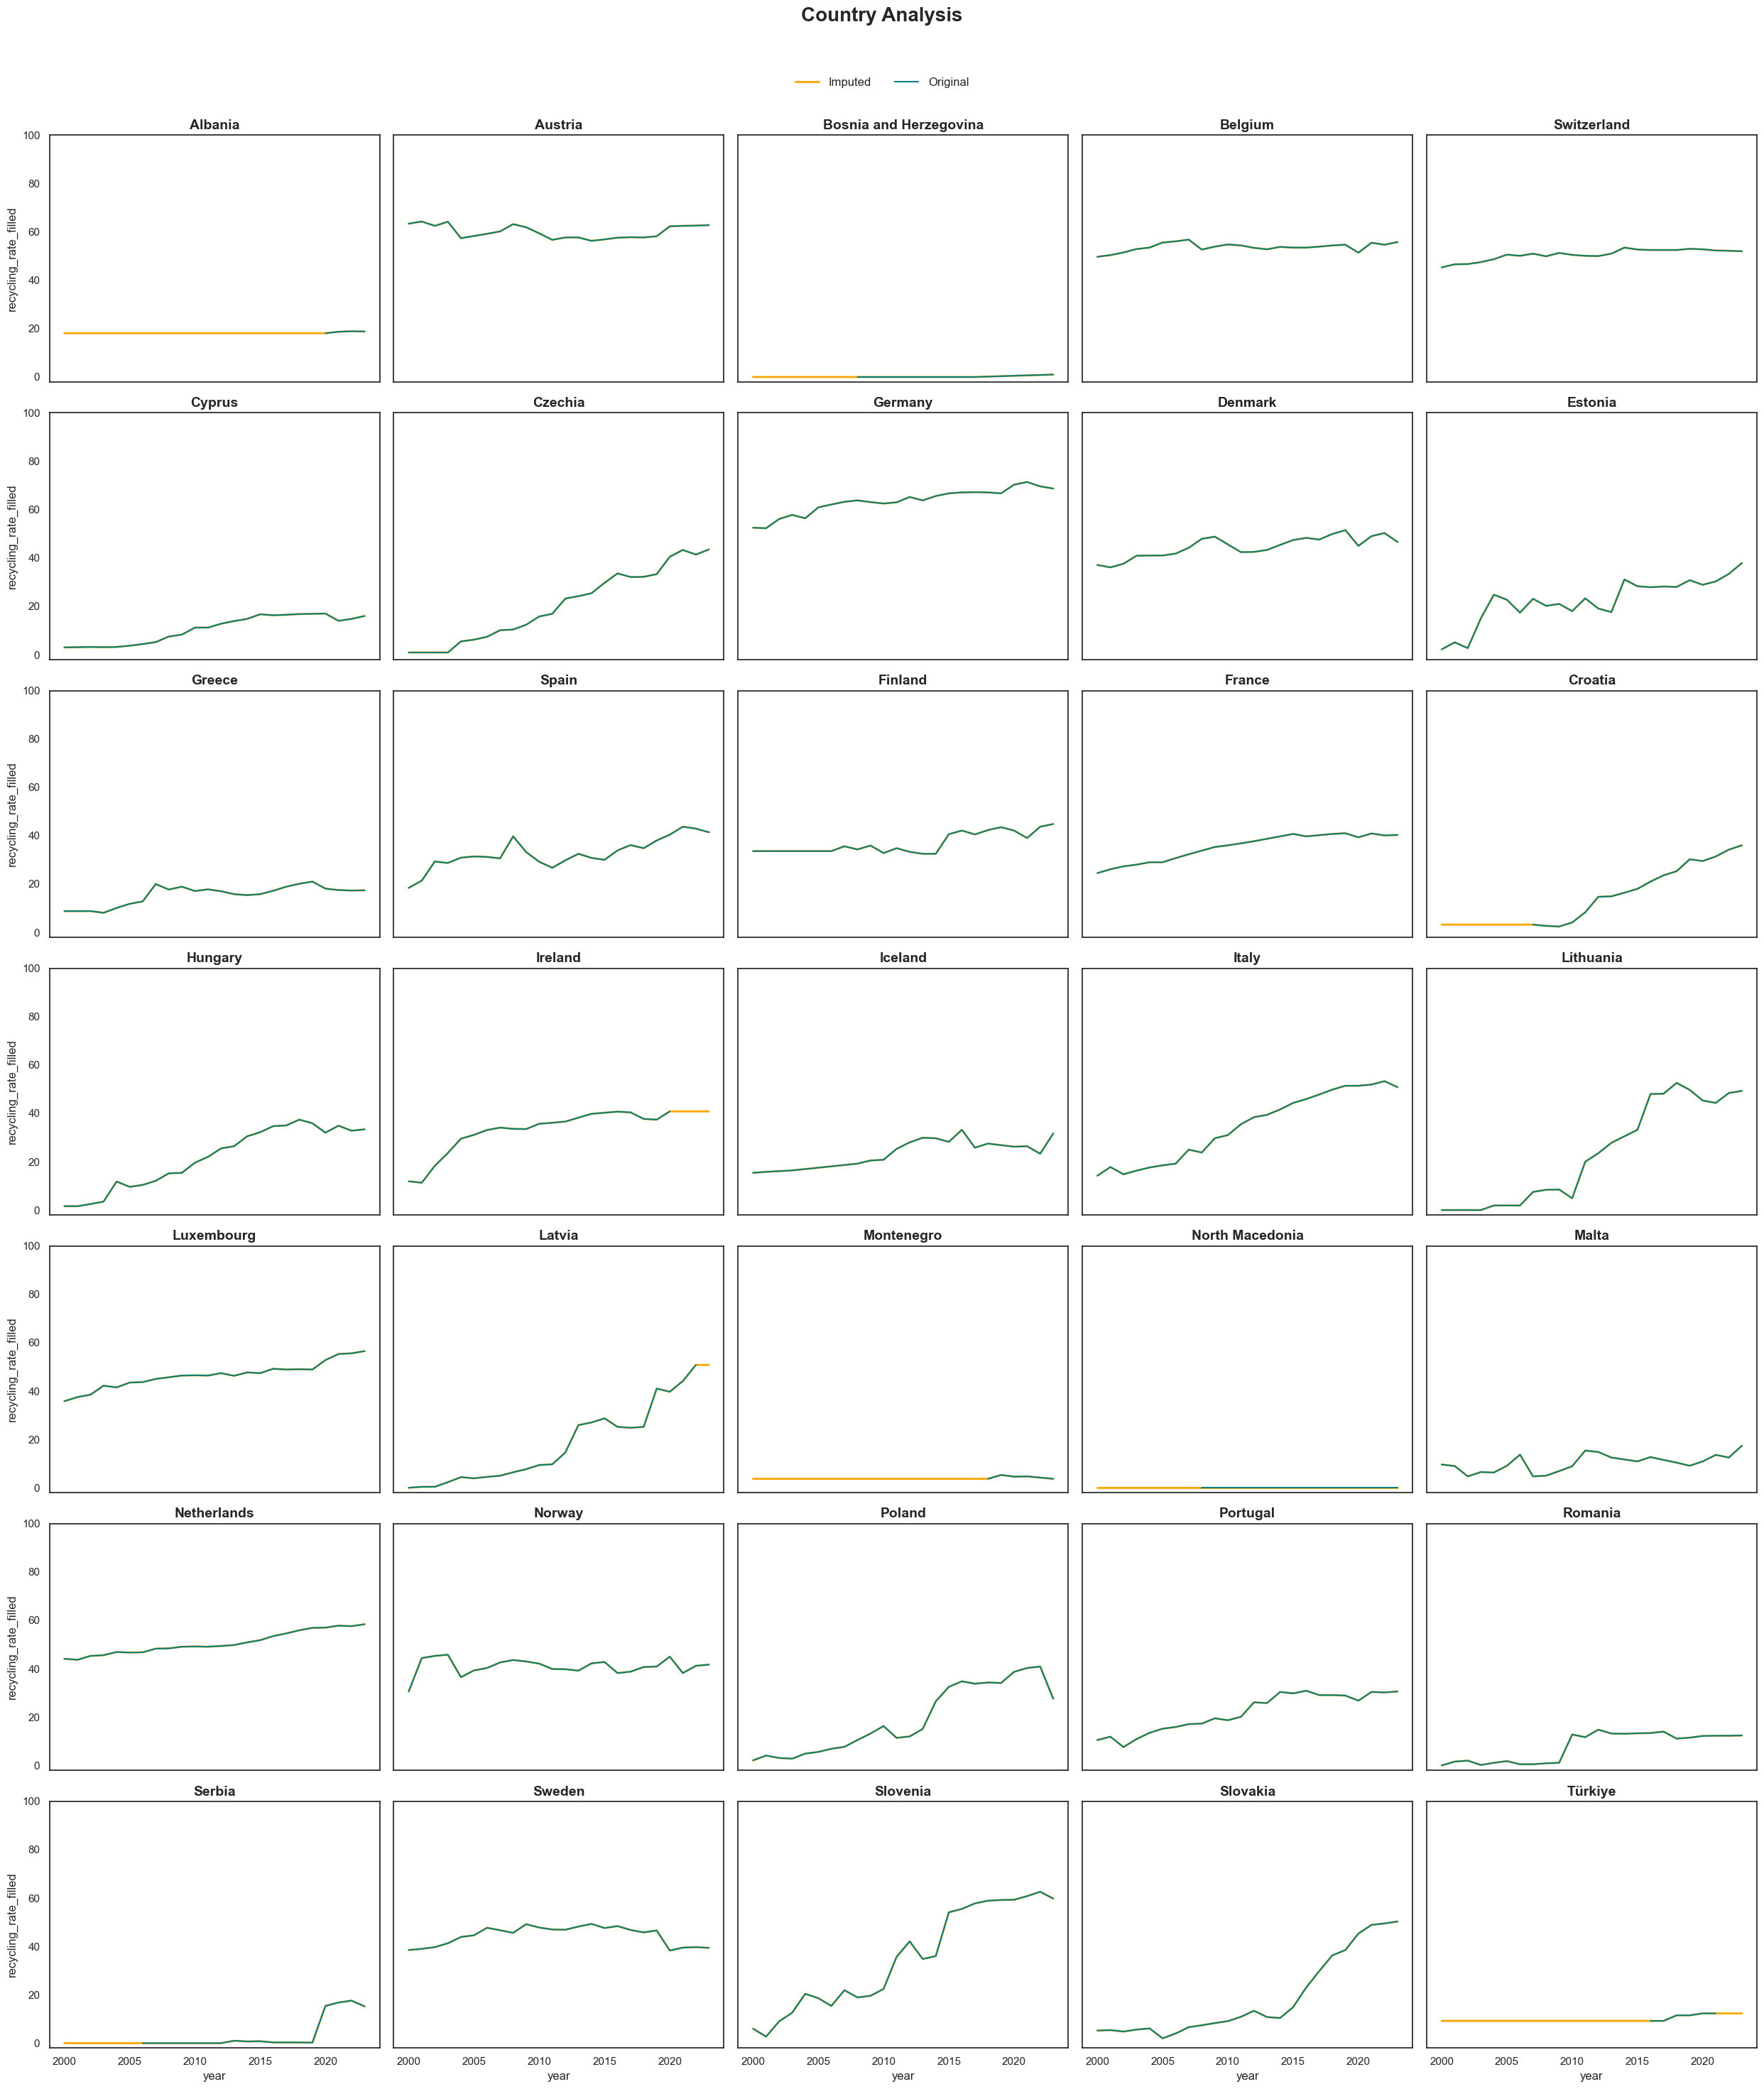

In [168]:
original_v_imputed = {
    'recycling_rate_filled': {'color': 'orange', 'lw': 2, 'alpha': 0.6, 'label': 'Imputed'},
    'recycling_rate': {'color': 'teal', 'lw': 1.5, 'marker': 'o', 'ms': 4, 'label': 'Original'}
}

plot_country_dashboard(res_d1_d3, original_v_imputed, cols=5);

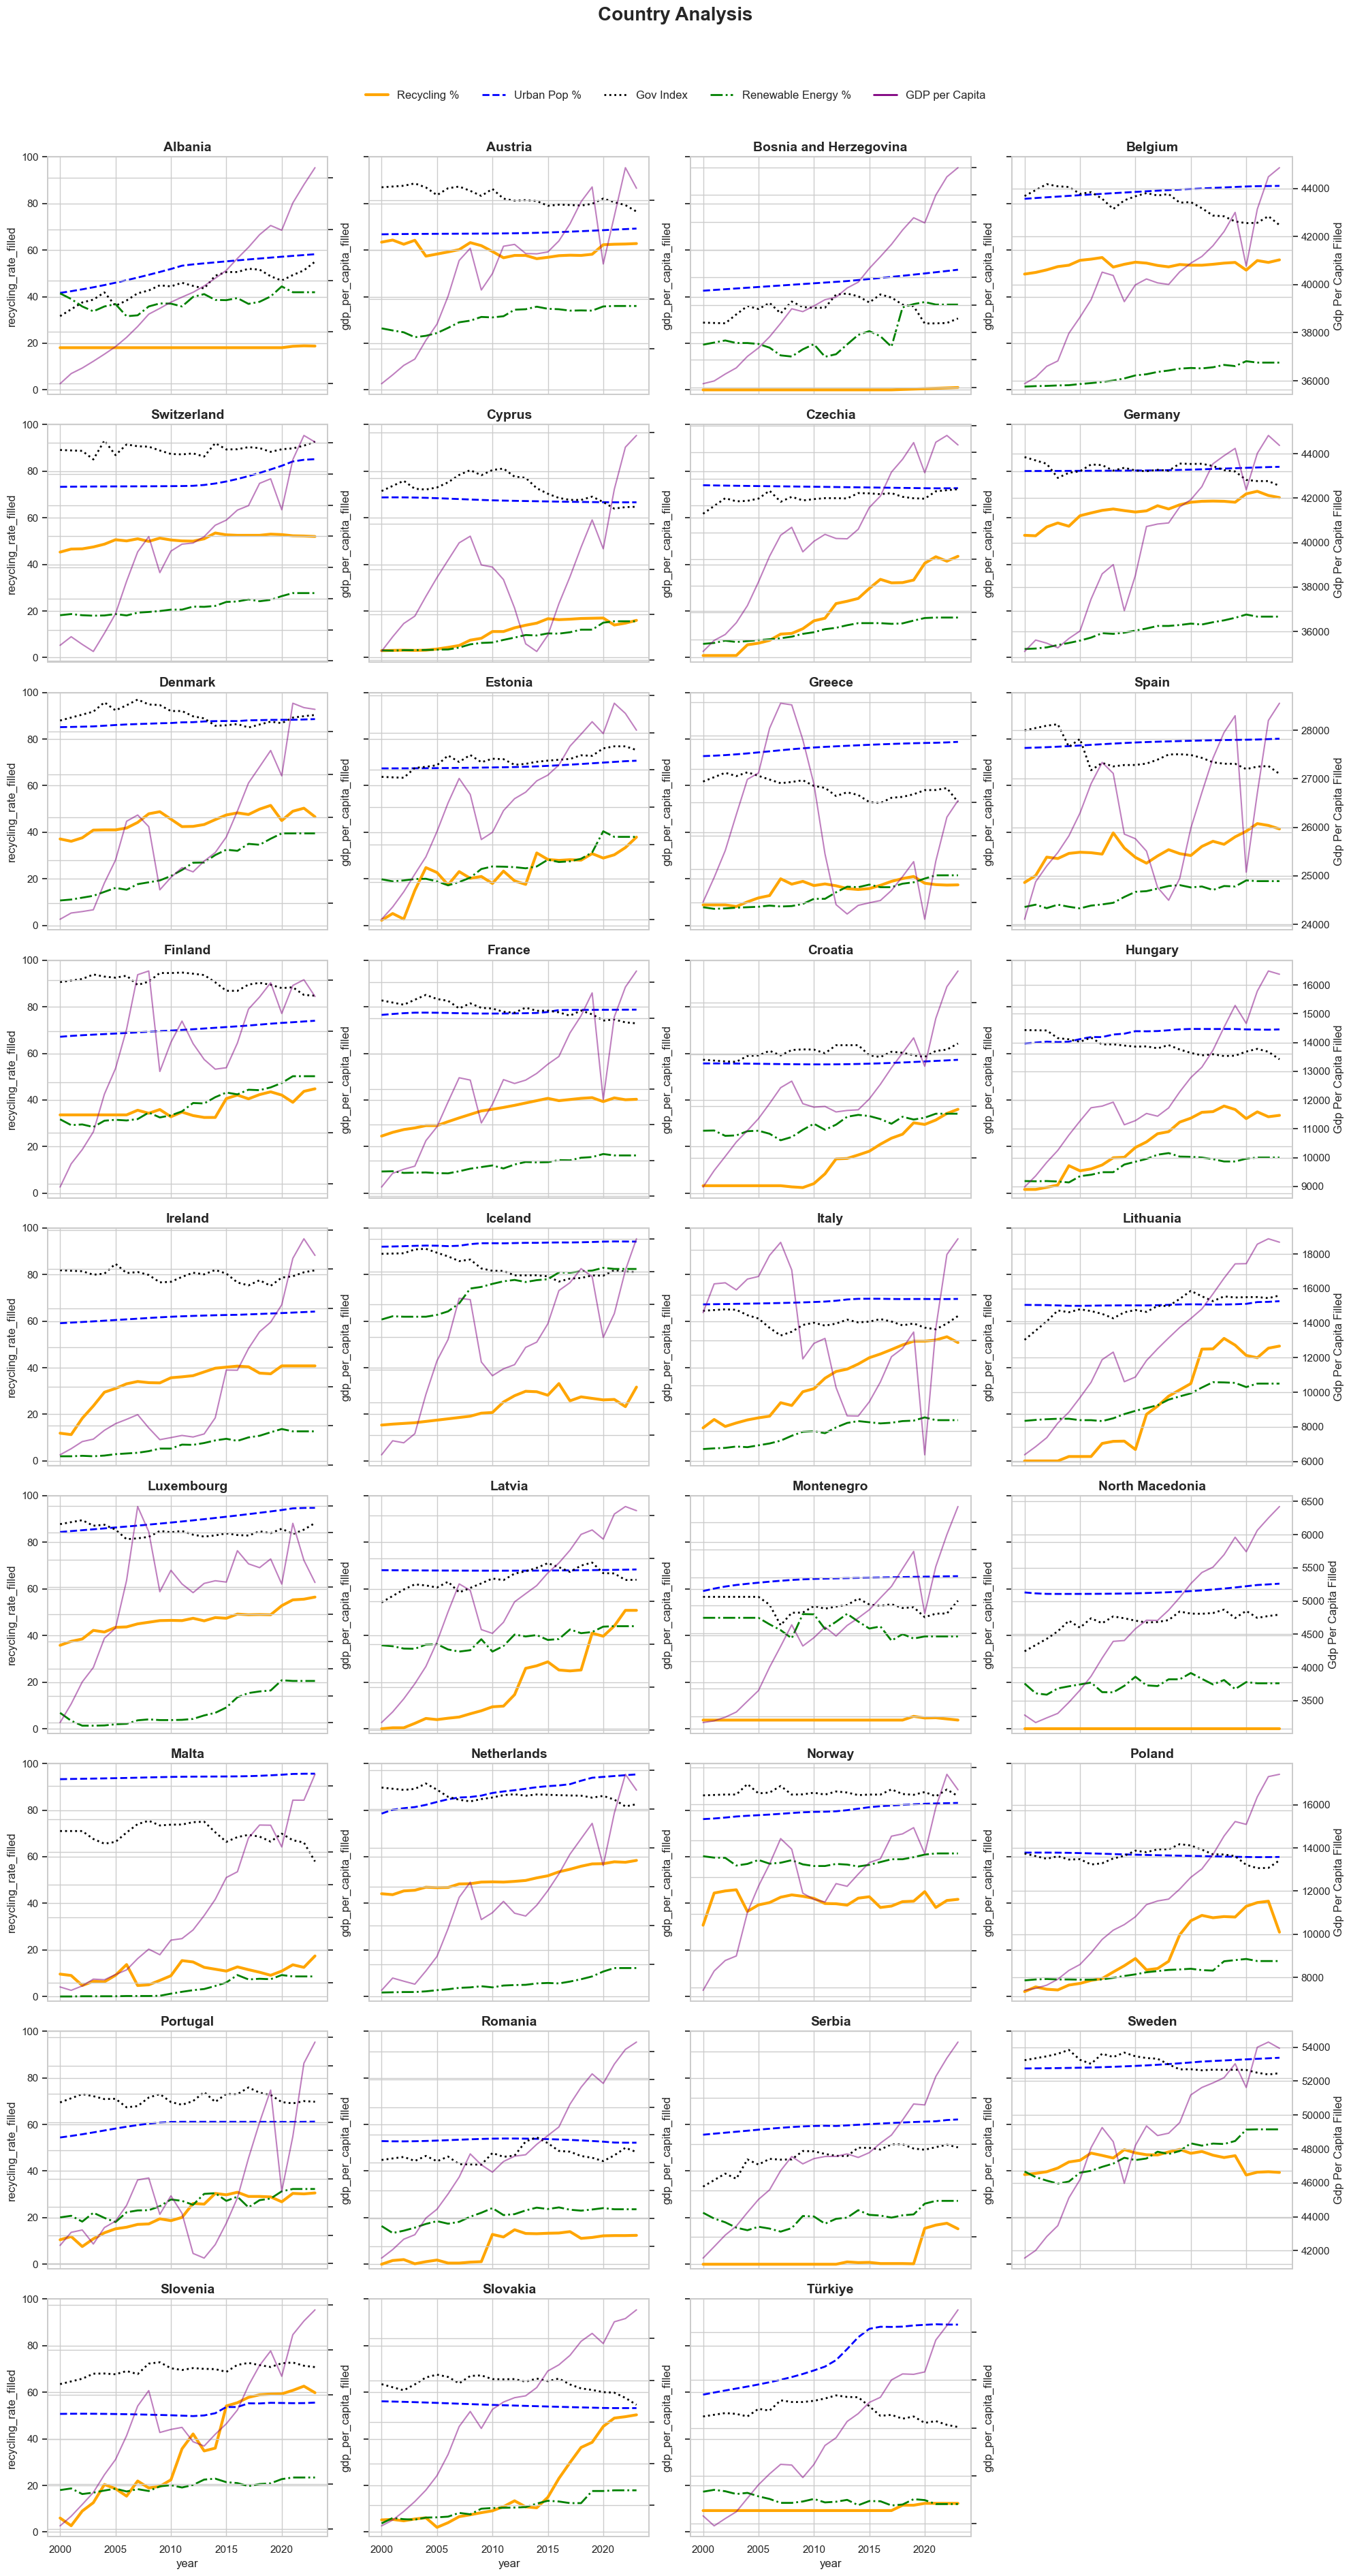

In [180]:
# Rescaling government effectiveness to 0-100 for better visualization since it is between -2.5 and 2.5
plot_df = res_d1_d3.copy()
plot_df['gov_effectiveness_index'] = ((plot_df['government_effectiveness_estimate_filled'] + 2.5) / 5 * 100)

# Primary metrics
metrics_config = {
    'recycling_rate_filled': {'color': 'orange', 'lw': 3, 'label': 'Recycling %'},
    'urban_population_pct_filled': {'color': 'blue', 'ls': '--', 'label': 'Urban Pop %'},
    'gov_effectiveness_index': {'color': 'black', 'ls': ':', 'label': 'Gov Index'},
    'renewable_energy_pct_filled': {'color': 'green', 'ls': '-.', 'label': 'Renewable Energy %'},
    'gdp_per_capita_filled': {'color': 'purple', 'ls': '-', 'label': 'GDP per Capita'}
}

plot_country_dashboard(plot_df, metrics_config, secondary_metric='gdp_per_capita_filled');

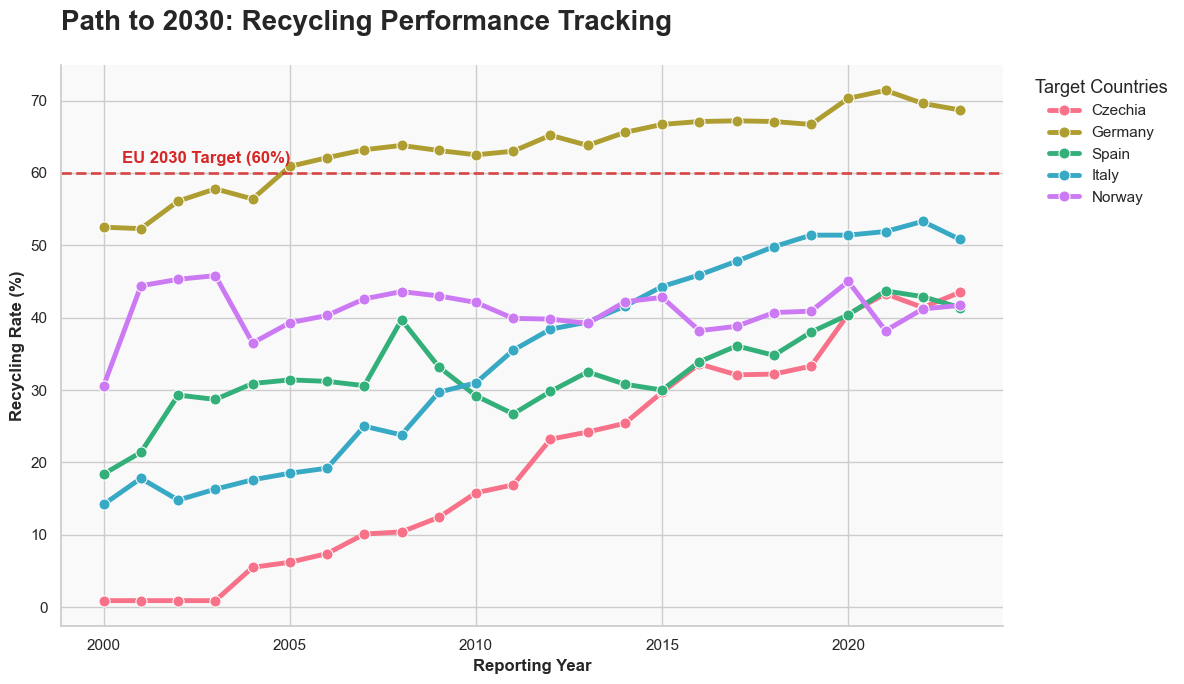

In [170]:
# Selecting 5 target countries for the management summary
targets = ['Germany', 'Norway', 'Italy', 'Czechia', 'Spain']
df_subset = res_d1_d3[res_d1_d3['country_name'].isin(targets)].copy()

sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#f9f9f9"})
plt.figure(figsize=(12, 7))

palette = sns.color_palette("husl", len(targets))

line_plot = sns.lineplot(
    data=df_subset, 
    x='year', 
    y='recycling_rate_filled', 
    hue='country_name', 
    linewidth=3.5,
    marker='o',
    markersize=8,
    markeredgecolor='white',
    palette=palette
)

# EU 2030 target line
plt.axhline(y=60, color='#d62728', linestyle='--', linewidth=2, alpha=0.8)

plt.text(2000.5, 61, 'EU 2030 Target (60%)', color='#d62728', 
         fontweight='bold', fontsize=12, va='bottom')

plt.title("Path to 2030: Recycling Performance Tracking", 
          fontsize=20, fontweight='bold', pad=25, loc='left')


plt.ylabel("Recycling Rate (%)", fontsize=12, fontweight='bold')
plt.xlabel("Reporting Year", fontsize=12, fontweight='bold')

plt.legend(title="Target Countries", title_fontsize='13', 
           fontsize='11', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

sns.despine()

plt.tight_layout()
plt.show()

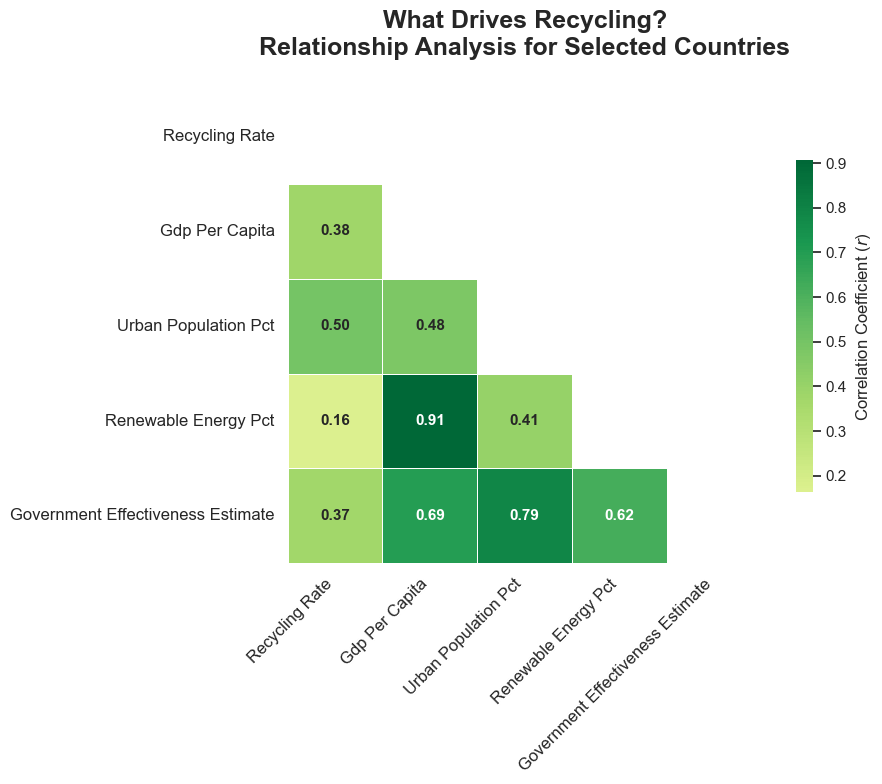

In [171]:
# Correlation analysis to identify drivers of recycling rates
core_indicators = [
    'recycling_rate_filled',
    'gdp_per_capita_filled',
    'urban_population_pct_filled',
    'renewable_energy_pct_filled',
    'government_effectiveness_estimate_filled']

sns.set_theme(style="white")
plt.figure(figsize=(10, 8))

df_corr = df_subset[core_indicators].corr()
df_corr.columns = [c.replace('_filled', '').replace('_', ' ').title() for c in df_corr.columns]
df_corr.index = [i.replace('_filled', '').replace('_', ' ').title() for i in df_corr.index]


mask = np.triu(np.ones_like(df_corr, dtype=bool))

sns.heatmap(
    df_corr, 
    mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap='RdYlGn', 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .7, "label": "Correlation Coefficient ($r$)"},
    annot_kws={"size": 11, "weight": "bold"}
)

plt.title("What Drives Recycling?\nRelationship Analysis for Selected Countries", 
          fontsize=18, pad=25, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

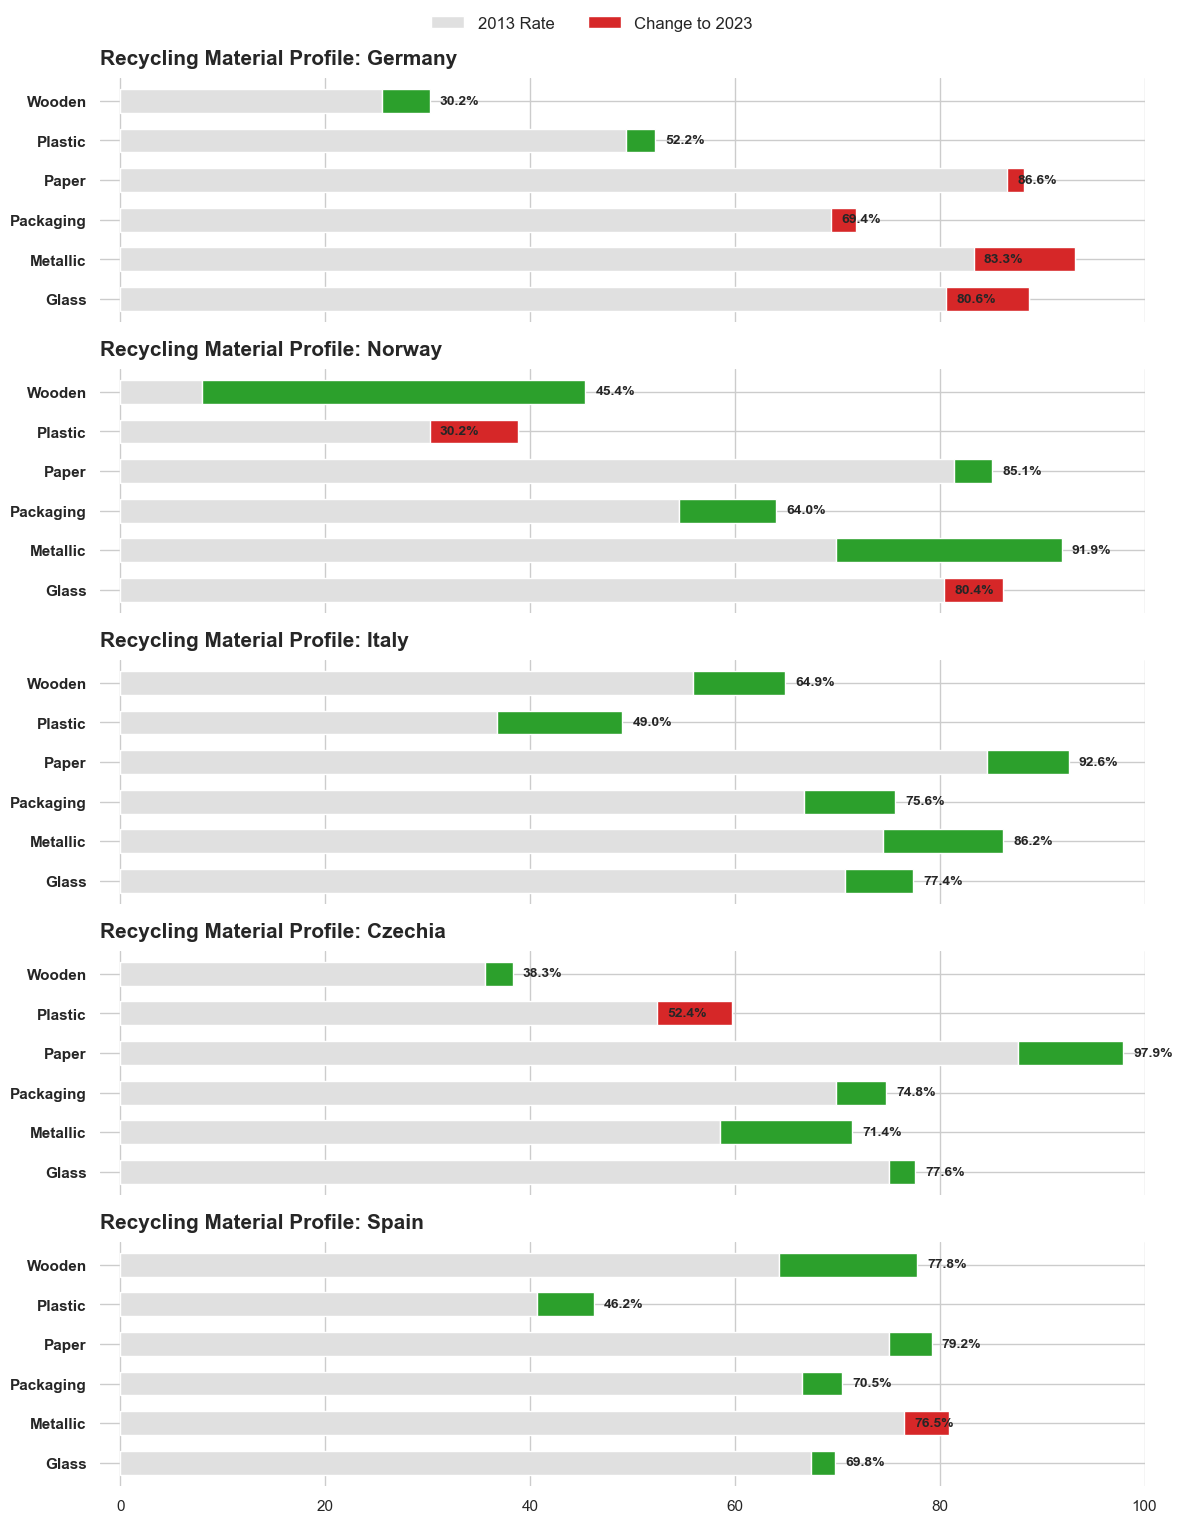

In [ ]:
# Selecting the same 5 target countries for horizontal comparison
targets = ['Germany', 'Norway', 'Italy', 'Czechia', 'Spain']
latest_year = res_d2_d3['year'].max()
material_cols = [c for c in res_d2_d3.columns if 'recycling_rate_filled_' in c]
material_labels = [m.replace('recycling_rate_filled_', '').title() for m in material_cols]

# Plotting horizontal bar charts for each country
fig, axes = plt.subplots(len(targets), 1, figsize=(12, len(targets) * 3), sharex=True)
sns.set_theme(style="whitegrid")

for i, country in enumerate(targets):
    ax = axes[i]
    
    # extract data points
    d2013 = res_d2_d3[(res_d2_d3['country_name'] == country) & (res_d2_d3['year'] == 2013)][material_cols].values.flatten()
    dLatest = res_d2_d3[(res_d2_d3['country_name'] == country) & (res_d2_d3['year'] == latest_year)][material_cols].values.flatten()
    
    y_pos = np.arange(len(material_labels))

    # Show the 2013 baseline
    ax.barh(y_pos, d2013, color='#e0e0e0', label='2013 Rate', height=0.6)
    
    # Show the improvement (green) or decline (red)
    diff = dLatest - d2013
    colors = ['#2ca02c' if x >= 0 else '#d62728' for x in diff]
    ax.barh(y_pos, diff, left=d2013, color=colors, label=f'Change to {latest_year}', height=0.6)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(material_labels, fontweight='bold', fontsize=11)
    ax.set_title(f"Recycling Material Profile: {country}", fontsize=15, fontweight='bold', loc='left', pad=10)
    ax.set_xlim(-2, 100) # Added padding at 0 to see small bars
    
    # data labels
    for j, val in enumerate(dLatest):
        ax.text(val + 1, j, f"{val:.1f}%", va='center', fontsize=10, fontweight='bold')

    sns.despine(left=True, bottom=True)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=2, frameon=False, fontsize=12)

plt.tight_layout()
plt.show()